In [52]:
import pandas as pd

cust_day_group = pd.read_parquet("../data/interim/cust_day_group.parquet")
cust_day_group.head()


,anon,date,MATRIX GRUPA PRODUKTOWA,matrix_qty,ILOŚĆ FILTRÓW,MATRIX NAZWA,is_purchase
0,ANON_0000001,11/9/22,03_butelki filtrujące SOLID,1.0,1.0,"SOLID 0,7 1F",True
1,ANON_0000001,11/9/22,06_filtry do butelek Soft i Solid,3.0,3.0,1 FILTR BUTELKOWY,True
2,ANON_0000001,11/9/22,07_akcesoria do Soft/Solid,1.0,0.0,"RURKA TRITANOWA DO SOLID 0,7",True
3,ANON_0000002,11/9/22,02_butelki filtrujące SOFT,2.0,2.0,"SOFT 0,5 1F",True
4,ANON_0000003,11/9/22,26_podgrzewacze przepływowe,1.0,0.0,PRZEPŁYWOWY PODGRZEWACZ - NADUMYLAWKOWY,True


## Load prepared daily customer-product table
Bullets:
Load cust_day_group.parquet which is already normalized + decoded (01–04 done).
Grain: one row per (anon, date, product group, product name) with quantities and flags.
This table is the base for repeat-rate + retention calculations.


### Quick schema sanity check
Bullets:
Confirm key columns exist: anon, date, MATRIX GRUPA PRODUKTOWA, matrix_qty, ILOŚĆ FILTRÓW, is_purchase.
Visually inspect that date looks parseable and purchase flags make sense.

In [53]:
customer_purchases = (
    cust_day_group[cust_day_group["is_purchase"]]
    .groupby("anon", as_index=False)
    .agg(
        n_purchase_days=("date", "nunique"),
        first_purchase=("date", "min"),
        last_purchase=("date", "max"),
    )
)

customer_purchases["is_repeat_customer"] = customer_purchases["n_purchase_days"] > 1


In [54]:
customer_purchases["is_repeat_customer"].value_counts(normalize=False)


is_repeat_customer
False    281745
True      52157
Name: count, dtype: int64

In [55]:
group_repeat_stats = (
    cust_day_group[cust_day_group["is_purchase"]]
    .groupby(["anon", "MATRIX GRUPA PRODUKTOWA"], as_index=False)
    .agg(n_purchase_days=("date", "nunique"))
)


## Compute repeat rate by product group

For each product group, we measure how often customers return to buy **the same product group again**.

- `customers`: number of unique customers who ever purchased from the product group
- `repeat_customers`: customers with purchases on more than one distinct purchase day
- `repeat_rate`: share of customers who returned at least once

This metric is used as a **high-level retention proxy** and does not yet account for:
- time between purchases,
- quantity stocked up,
- or equipment owned (handled in later steps).


In [56]:
product_group_retention = (
    group_repeat_stats
    .groupby("MATRIX GRUPA PRODUKTOWA", as_index=False)
    .agg(
        customers=("anon", "nunique"),
        repeat_customers=("n_purchase_days", lambda x: (x > 1).sum()),
    )
)

product_group_retention["repeat_rate"] = (
    product_group_retention["repeat_customers"]
    / product_group_retention["customers"]
)

product_group_retention.sort_values("repeat_rate", ascending=False)


,MATRIX GRUPA PRODUKTOWA,customers,repeat_customers,repeat_rate
30,32_nabój CO2 - wymiana,2508,842,0.335726
20,21_wkład D1 do Flow Comfort,3031,720,0.237545
23,24_Filtry przepływowe - wkłady,7391,1599,0.216344
21,22_wkład DC10 do Flow Comfort,1744,297,0.170298
26,27_Proskin - urządzenia i filtry,435,68,0.156322
15,16_filtry do dzbanków AGD+,14722,2261,0.153580
5,06_filtry do butelek Soft i Solid,119603,15595,0.130390
13,14_filtry do dzbanków Mg+,11272,1468,0.130234
14,15_filtry do dzbanków Ph+,1568,180,0.114796
6,07_akcesoria do Soft/Solid,34822,3696,0.106140


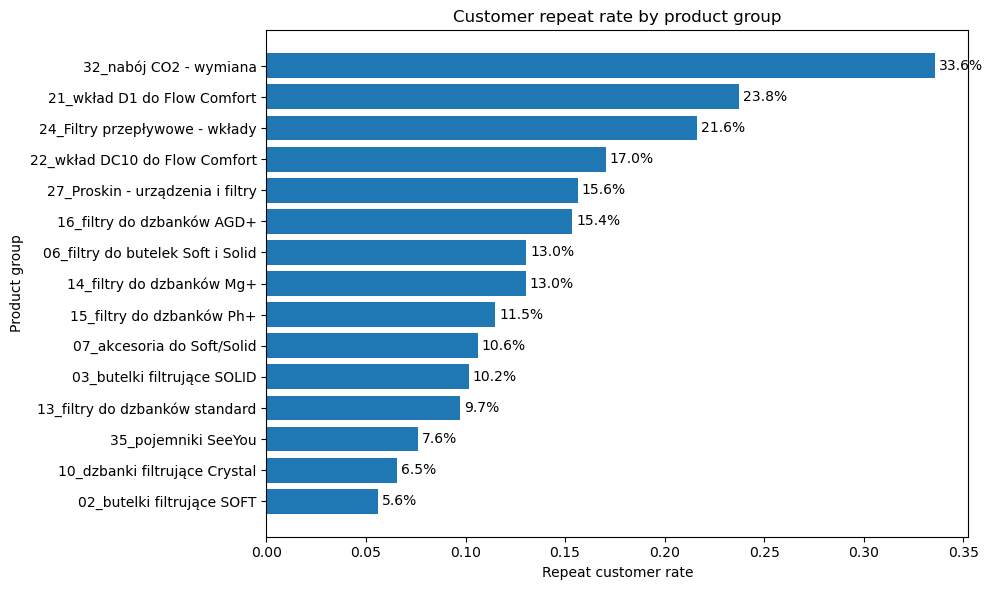

In [80]:
plot_df = (
    product_group_retention
    .sort_values("repeat_rate", ascending=True)   # ascending for horizontal bars
    .tail(15)                                     # top 15 by repeat rate
)


import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

plt.barh(
    plot_df["MATRIX GRUPA PRODUKTOWA"],
    plot_df["repeat_rate"]
)

for i, v in enumerate(plot_df["repeat_rate"]):
    plt.text(v + 0.002, i, f"{v:.1%}", va="center")

plt.xlabel("Repeat customer rate")
plt.ylabel("Product group")
plt.title("Customer repeat rate by product group")

plt.tight_layout()
plt.savefig("../plots/product_repeat_rates.png")
plt.show()



## Prepare purchase-level table (clean dates, sort, create lag features)
We restrict to is_purchase==True
Parse date with dayfirst=True
Sort and compute prev_date per (anon, product_group)
Compute delta_days

## Retention (unadjusted): days between repurchases
Uses delta_days between consecutive purchases in the same product group
Aggregated by product group → mean/median + interval count

## Retention (quantity-adjusted): stock-up aware
Adjust by previous purchase quantity: adj_retention_days = delta_days / prev_qty
Median is preferred for client-facing summary (less sensitive to outliers)

In [77]:
import pandas as pd
import numpy as np

# -------------------------
# 1) Prepare purchase-level table
# -------------------------
df_purchases = cust_day_group[cust_day_group["is_purchase"]].copy()

df_purchases["date"] = pd.to_datetime(
    df_purchases["date"],
    errors="coerce",
    dayfirst=True
)
df_purchases = df_purchases.dropna(subset=["date"])

# Sort so groupby().shift() is correct
df_purchases = df_purchases.sort_values(
    ["anon", "MATRIX GRUPA PRODUKTOWA", "date"]
)

# Lag features per customer & product group
df_purchases["prev_date"] = (
    df_purchases
    .groupby(["anon", "MATRIX GRUPA PRODUKTOWA"])["date"]
    .shift(1)
)

df_purchases["prev_qty"] = (
    df_purchases
    .groupby(["anon", "MATRIX GRUPA PRODUKTOWA"])["matrix_qty"]
    .shift(1)
)

# Time between purchases
df_purchases["delta_days"] = (
    df_purchases["date"] - df_purchases["prev_date"]
).dt.days

# Keep only valid repurchase intervals
df_deltas = df_purchases[df_purchases["delta_days"].notna()].copy()


# -------------------------
# 2) Unadjusted retention stats (days between repurchases)
# -------------------------
retention_stats = (
    df_deltas
    .groupby("MATRIX GRUPA PRODUKTOWA", as_index=False)
    .agg(
        avg_retention_days=("delta_days", "mean"),
        median_retention_days=("delta_days", "median"),
        n_intervals=("delta_days", "count"),
    )
)


# -------------------------
# 3) Quantity-adjusted retention stats (stock-up aware)
#    adj_days = days_between / previous_quantity
# -------------------------
df_adj = df_deltas[
    df_deltas["prev_qty"].notna() & (df_deltas["prev_qty"] > 0)
].copy()

df_adj["adj_retention_days"] = df_adj["delta_days"] / df_adj["prev_qty"]

adjusted_retention_stats = (
    df_adj
    .groupby("MATRIX GRUPA PRODUKTOWA", as_index=False)
    .agg(
        avg_adj_retention_days=("adj_retention_days", "mean"),
        median_adj_retention_days=("adj_retention_days", "median"),
        n_intervals_adj=("adj_retention_days", "count"),
    )
)


# -------------------------
# 4) Merge into final product-group table
# -------------------------
product_group_retention_final = (
    product_group_retention
    .merge(retention_stats, on="MATRIX GRUPA PRODUKTOWA", how="left")
    .merge(adjusted_retention_stats, on="MATRIX GRUPA PRODUKTOWA", how="left")
    .sort_values("repeat_rate", ascending=False)
)

product_group_retention_final.head()


/var/folders/2w/84n_l6ld0kq5y9sp9jw4q50c0000gn/T/ipykernel_36504/2187037356.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_purchases["date"] = pd.to_datetime(


,MATRIX GRUPA PRODUKTOWA,customers,repeat_customers,repeat_rate,avg_retention_days,median_retention_days,n_intervals,avg_adj_retention_days,median_adj_retention_days,n_intervals_adj
30,32_nabój CO2 - wymiana,2508,842,0.335726,76.698258,54.0,1952.0,72.497222,50.0,1952.0
20,21_wkład D1 do Flow Comfort,3031,720,0.237545,185.556184,126.0,1237.0,160.981541,102.0,1237.0
23,24_Filtry przepływowe - wkłady,7391,1599,0.216344,254.430990,212.0,2717.0,84.528491,49.0,2717.0
21,22_wkład DC10 do Flow Comfort,1744,297,0.170298,219.667447,184.0,427.0,202.739071,182.0,427.0
26,27_Proskin - urządzenia i filtry,435,68,0.156322,134.592593,101.0,81.0,108.435802,72.0,81.0


> Note: Retention periods are computed only for customers with at least two purchases
> within the same product group. Single-purchase customers do not generate a retention
> interval and are excluded from these calculations.


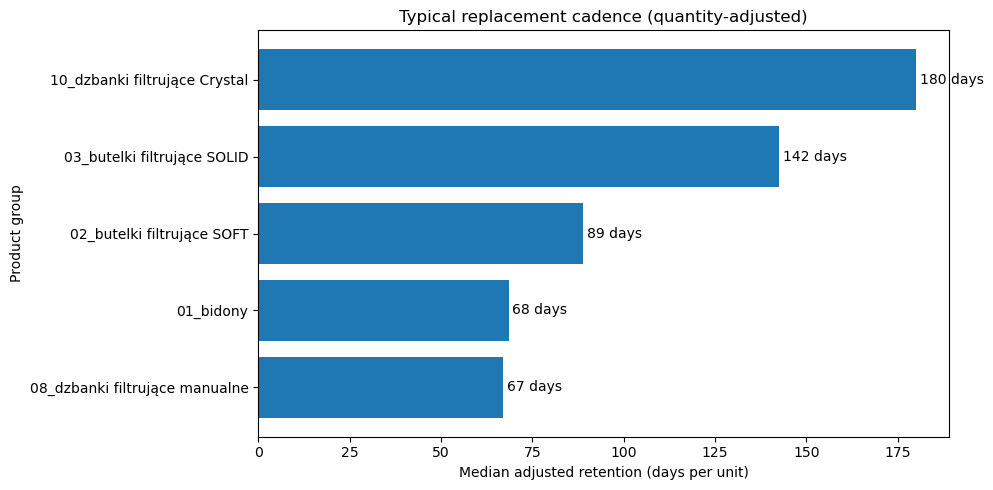

In [81]:
PRODUCTS = [
    "03_butelki filtrujące SOLID",
    "10_dzbanki filtrujące Crystal",
    "01_bidony",
    "02_butelki filtrujące SOFT",
    "08_dzbanki filtrujące manualne",
]

plot_df = (
    product_group_retention_final
    .query("`MATRIX GRUPA PRODUKTOWA` in @PRODUCTS")
    .sort_values("median_adj_retention_days", ascending=True)
)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.barh(
    plot_df["MATRIX GRUPA PRODUKTOWA"],
    plot_df["median_adj_retention_days"]
)

for i, v in enumerate(plot_df["median_adj_retention_days"]):
    plt.text(v + 1, i, f"{v:.0f} days", va="center")

plt.xlabel("Median adjusted retention (days per unit)")
plt.ylabel("Product group")
plt.title("Typical replacement cadence (quantity-adjusted)")
plt.savefig("../plots/retention_per_product.png")
plt.tight_layout()
plt.show()




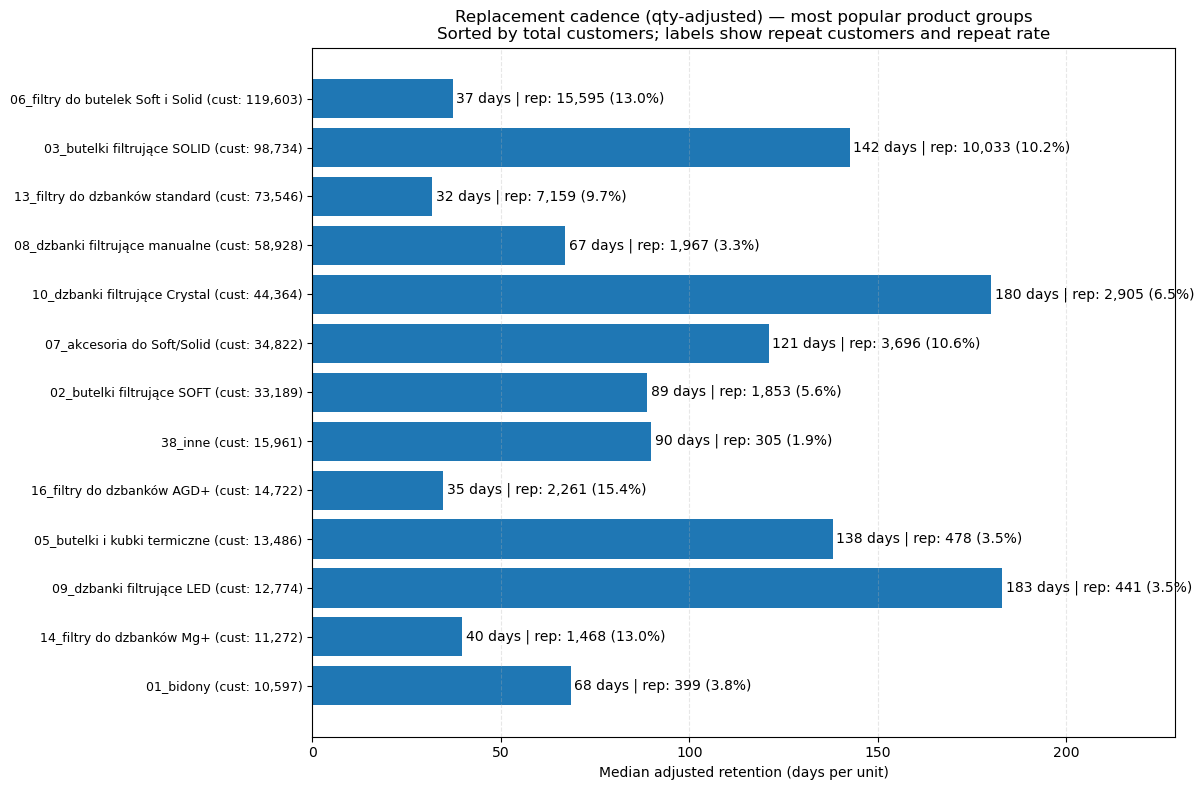

In [89]:
MIN_CUSTOMERS = 10_000

plot_df = (
    product_group_retention_final
    .loc[product_group_retention_final["customers"] > MIN_CUSTOMERS]
    .sort_values("customers", ascending=True)
    .copy()
)

# y-axis labels with customer count
plot_df["y_label"] = plot_df.apply(
    lambda r: f"{r['MATRIX GRUPA PRODUKTOWA']} (cust: {int(r['customers']):,})",
    axis=1
)

plt.figure(figsize=(12, 8))
plt.barh(plot_df["y_label"], plot_df["median_adj_retention_days"])

for i, r in enumerate(plot_df.itertuples(index=False)):
    v = r.median_adj_retention_days
    if pd.notna(v):
        plt.text(
            v + 1,
            i,
            f"{v:.0f} days | rep: {int(r.repeat_customers):,} ({r.repeat_rate:.1%})",
            va="center"
        )

plt.xlabel("Median adjusted retention (days per unit)")
plt.ylabel("")
plt.title(
    "Replacement cadence (qty-adjusted) — most popular product groups\n"
    "Sorted by total customers; labels show repeat customers and repeat rate"
)

xmax = plot_df["median_adj_retention_days"].max()
plt.xlim(0, xmax * 1.25)
plt.yticks(fontsize=9)
# and in the label:
# f"{group} (N: {customers:,})"

plt.grid(axis="x", linestyle="--", alpha=0.3)


plt.tight_layout()
plt.savefig("../plots/retention_popular_sorted_by_customers.png", dpi=200, bbox_inches="tight")
plt.show()


In [90]:
product_group_retention_final.to_parquet(
    "../data/interim/product_group_retention.parquet",
    index=False
)


purchase_intervals = df_adj[
    [
        "anon",
        "MATRIX GRUPA PRODUKTOWA",
        "date",
        "prev_date",
        "delta_days",
        "prev_qty",
        "adj_retention_days",
    ]
].copy()

purchase_intervals.to_parquet(
    "../data/interim/purchase_intervals.parquet",
    index=False
)

retention_benchmarks = (
    purchase_intervals
    .groupby("MATRIX GRUPA PRODUKTOWA")
    .agg(
        p25=("adj_retention_days", lambda x: x.quantile(0.25)),
        median=("adj_retention_days", "median"),
        p75=("adj_retention_days", lambda x: x.quantile(0.75)),
    )
    .reset_index()
)

retention_benchmarks.to_parquet(
    "../data/interim/retention_benchmarks.parquet",
    index=False
)


## Notebook output and next steps

This notebook produces aggregated and customer-level retention signals used as inputs
for live customer equipment modeling.

Saved outputs:
- Product-group retention benchmarks
- Customer-level purchase intervals (quantity-adjusted)

Next notebook:
- Build live customer equipment state
- Track time since last replacement per product
- Identify upcoming and overdue replacement events
